# Survival Analysis in International Rugby Union

Survival analysis is a statistical tool used to measure the expected duration or time unil and event happens. In this context, it will be used to look at the longevity of international rugby careers and assess the probabilty of a player still playing international rugby after a given number of years. The [Premiership Rugby Injury Surveillance Project](https://www.englandrugby.com/dxdam/96/960006d9-269d-4250-a15f-d9e62f8bfe70/PRISP_1718.pdf) shows that injury severity is increasing year by year with injury rates not changing significantly illustrating more players retire due to injury than previously meaning careers may potentially shorter. Alongside this, international careers depend on many factors such as playing form and availability. I will use survival anlysis to analyse the length of international playing careers and the probablity of still playing from one year to the next

## Survival Function
The survival function is a function that gives the probability of a person surviving after a given time such that:

\begin{align*}
S(t) = Pr(T > t)
\end{align*}

Where $S$ is the probability a person survives past a specific number of years $t$.
In the context of this analysis $S(5)$ would be the probabilty that a player is still playing international rugby 5 years after their first international rugby cap.
I will use the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) to calculate $S(t)$ where:
\begin{align*}
\hat{S_{t}} = \displaystyle\prod_{t_{t}{\leq}t}\left[1 - \frac{d_{i}}{n_{i}}\right]
\end{align*}
* $\hat{S_{T}}$ is the estimator of the survival function
* $d$ - the number of deaths (in this case people who no longer play international rugby) at time $t$
* and $n$ - the total number of people survived $t$ years (that is, the number of people still playing after t years)  

For the Kaplan-Meier estimate I will use right-censorship to ensure those players who are currently still playing international rugby are not counted as retired at $t$ years.

## Retrieving the Data
I will scrape data from [ESPNScrums Statguru](http://stats.espnscrum.com/statsguru/rugby/stats/index.html) website which contains data for international rugby matches

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

/home/grant/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Dictionary of parameters to use with POST request
payload = {
    'class':1,
    'template':'results',
    'type':'player'
}

url = 'http://stats.espnscrum.com/statsguru/rugby/stats/index.html'

r = requests.post(
    url,
    data = payload
)

# Use BeautifulSoup to parse data
soup = BeautifulSoup(r.text)

# Find all the table headers and create a list of them.
table_headers = soup.findAll('th')
headers = [h.text for h in table_headers]

# Create a dictionary to store table data
data_dict = {h:[] for h in headers[:-1]}

There are 405 pages to iterate through to retrieve all the data. This data was scraped using the function below and stored as a csv file. The function will check for the csv file first and if this is not present will scrape all 405 pages (this could take some time to ensure not getting blocked)

In [3]:
base_url = 'http://stats.espnscrum.com/statsguru/rugby/stats/index.html'

In [4]:
def scrape_data(base_url, data_dict, no_pages):
    
    # Data will be loaded from csv file if file available to save tim eon web scraping
    if os.path.exists('survival_analysis.csv'):
        return pd.read_csv('survival_analysis.csv')
    
    else:
        # Pages range from 1-405
        for page in range(1,no_pages+1): 
            # A post request did not work so iterating through each page
            r = requests.get(base_url + f'?class=1;page={page};template=results;type=player')
            soup = BeautifulSoup(r.text)
            tables = soup.findAll('tr', {'class':'data1'})
            for table in tables:
                data_list = table.text.split('\n')
                data_list = [stat for stat in data_list if not stat == '' ]
                for stat, key in zip(data_list, data_dict.keys()):
                    data_dict[key].append(stat)
            time.sleep(1)

        return data_dict
            
            

In [5]:
base_url = 'http://stats.espnscrum.com/statsguru/rugby/stats/index.html'
no_pages = 405

data = scrape_data(base_url, data_dict, no_pages)
df = pd.DataFrame(data)

In [6]:
df.head()

,Player,Span,Mat,Start,Sub,Pts,Tries,Conv,Pens,Drop,GfM,Won,Lost,Draw,%
0,RH McCaw (NZ),2001-2015,148,141,7,135,27,0,0,0,0,131,15,2,89.18
1,AW Jones (Lions/Wales),2006-2020,147,134,13,45,9,0,0,0,0,73,72,2,50.34
2,SM Parisse (Italy),2002-2019,142,139,3,83,16,0,0,1,0,35,106,1,25.00
3,BG O'Driscoll (Ire/Lions),1999-2014,141,140,1,250,47,0,0,5,0,82,57,2,58.86
4,GM Gregan (Aust),1994-2007,139,133,6,99,18,0,0,3,0,93,44,2,67.62


In [7]:
# Separate start and finish years of international career
df['start'] = df['Span'].str.split('-', expand=True)[0]
df['finished'] = df['Span'].str.split('-', expand=True)[1]

In [8]:
# Exclude entries from before professional era
df_pro = df[df['start'] >= '1996']

# Convert str to int
df_pro['start'] = df_pro['start'].astype(int)
df_pro['finished'] = df_pro['finished'].astype(int)

/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
# Years are inclusive so add  1 year, else person who plays in 1 season will show 0
df_pro['duration'] = df_pro['finished'] - df_pro['start'] + 1

/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Add column if player retired or not
df_pro['retired'] = np.where(df_pro['finished'] >= 2019, 0, 1)

/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
df_pro.head()

,Player,Span,Mat,Start,Sub,Pts,Tries,Conv,Pens,Drop,GfM,Won,Lost,Draw,%,start,finished,duration,retired
0,RH McCaw (NZ),2001-2015,148,141,7,135,27,0,0,0,0,131,15,2,89.18,2001,2015,15,1
1,AW Jones (Lions/Wales),2006-2020,147,134,13,45,9,0,0,0,0,73,72,2,50.34,2006,2020,15,0
2,SM Parisse (Italy),2002-2019,142,139,3,83,16,0,0,1,0,35,106,1,25.00,2002,2019,18,0
3,BG O'Driscoll (Ire/Lions),1999-2014,141,140,1,250,47,0,0,5,0,82,57,2,58.86,1999,2014,16,1
5,GD Jenkins (Lions/Wales),2002-2016,134,98,36,20,4,0,0,0,0,61,70,3,46.64,2002,2016,15,1


## Descriptive Stats

In [12]:
# Function to return some basic stats on the data
def descriptive_stats(df):
    players = df.shape[0]
    mean_career = df_pro['duration'].mean()
    median_career = df_pro['duration'].median()
    retired = df_pro['retired'].value_counts()[1]
    not_retired = df_pro['retired'].value_counts()[0]
    first_cap = df_pro['start'].mean()
    last_cap = df_pro['finished'].mean()

    print(f"Number of players in dataset: {players}")
    print(f"Mean international career length: {mean_career:.2f}")
    print(f"Median international career length: {median_career}")
    print(f"Number of players retired: {retired}")
    print(f"Number of players still playing: {not_retired}")
    print(f"Average year of first cap: {first_cap:.0f}")
    print(f"Average year of most recent cap: {last_cap:.0f}")

In [13]:
descriptive_stats(df_pro)

Number of players in dataset: 8058
Mean international career length: 3.80
Median international career length: 2.0
Number of players retired: 6623
Number of players still playing: 1435
Average year of first cap: 2008
Average year of most recent cap: 2011


The above shows some basic statistics on the data. A sample of 8085, with 6623 having retired and a mean and median career length of 3.8 and 2.0 years respectively. At this point, this doesn't take into account the fact that some players are still playing but this will be considered during the survival analysis

In [14]:
# Extract player names and countries represented from the player columns
pattern = '\((.*?)\)'
df_pro['country'] = df_pro['Player'].str.extract(pattern)
pattern = "([^\(]+)"
df_pro['name'] = df_pro['Player'].str.extract(pattern)

/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


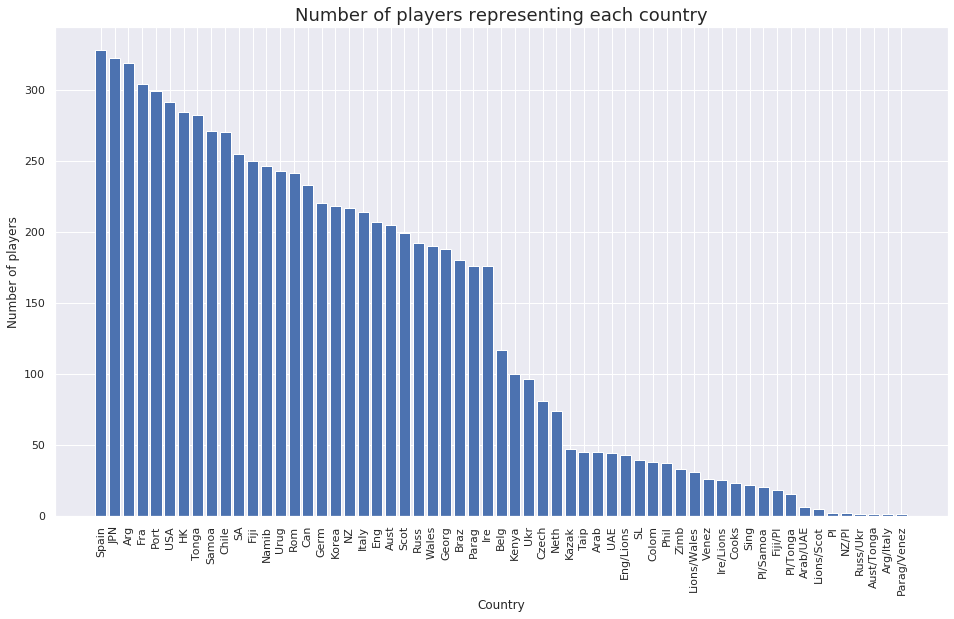

In [15]:
def plot_countries(series):
    plt.figure(figsize=(16,9))
    plt.bar(series.value_counts().index,series.value_counts())
    plt.xticks(rotation=90)
    plt.xlabel('Country')
    plt.ylabel('Number of players')
    plt.title('Number of players representing each country', fontdict={'size':18})
    plt.show()
    
plot_countries(df_pro['country'])

The graph above illustrates the number of players representing each country in the sample. It appears some of the less well developed rugby nations have a greater turnover of players which may not be suprising as many of these players may move abroad or make themselves unavailable for selection if they deem the level of competition isn't high enough. The data for the four home nations (England, Scotland, Ireland, Wales) also appears lower than what it should actually be but a proportion of these players are in a separated 'Eng/Lions' category. There are also a subset of players who have represented several nation as can be seen on the right of the graph

In [16]:
def ave_career(df):
    country_ave = df.groupby('country').mean()['duration'].sort_values(ascending=False)
    plt.figure(figsize=(16,9))
    plt.bar(country_ave.index, country_ave)
    plt.xticks(rotation=90)
    plt.xlabel('Country')
    plt.ylabel('Years played for country')
    plt.title('Average length of international career', fontdict={'size':18})
    plt.show()

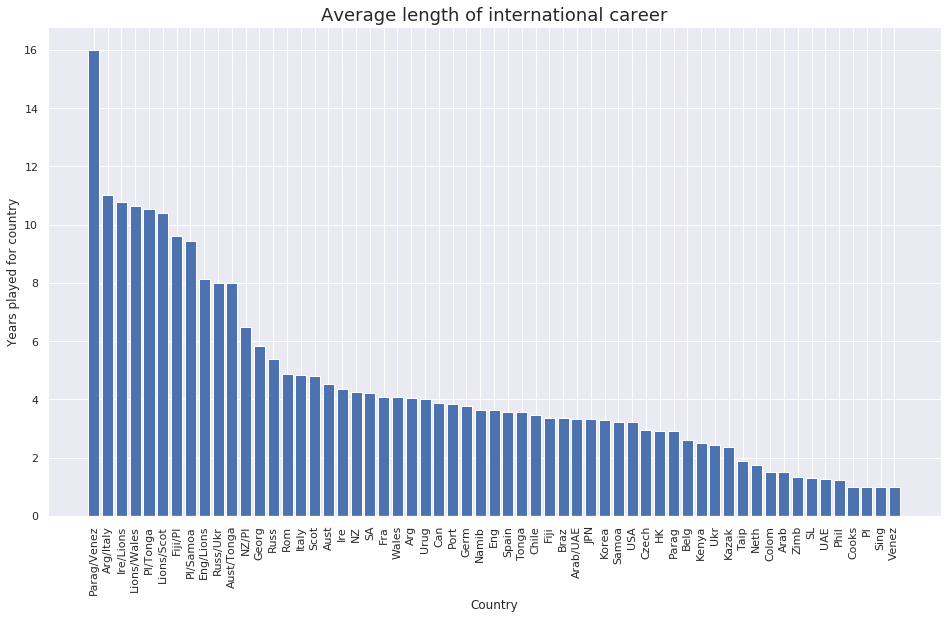

In [17]:
ave_career(df_pro)

We can see from the graph above that the avergae career length ranges from 16 to 1 year. The majority of players with longer career lengths are those who have either represented 2 countries or represented their country and the Lions. The players who have represented 2 countries most likely weren't good enough to continue playing for 1 country so found a way to represent another country and thereby lengthen their international career. The players who have represented both a country and the Lions are most likely to be the better players and hence why they play for longer

There is a big difference in international rugby between the top teams and the lower teams so I will look at how these differ

In [18]:
# How many unique countries
print(df_pro['country'].unique())

# Create list of top tier teams
top_tier = ['NZ', 'Italy', 'Ire/Lions', 'Lions/Wales','Aust', 'SA', 'Ire',
           'Lions/Scot', 'Scot', 'Eng/Lions', 'Fra', 'Eng', 'Arg', 'Wales']

# Map whether a team is a top tier of lower tier team to dataframe
tier_mask = df_pro['country'].isin(top_tier)
df_pro['tier'] = tier_mask.astype(int)
df_pro['tier'] = df_pro['tier'].map(lambda x: 'top' if x == 1 else 'bottom')

['NZ' 'Lions/Wales' 'Italy' 'Ire/Lions' 'Aust' 'SA' 'Ire' 'Rom' 'Georg'
 'Russ' 'Lions/Scot' 'Scot' 'Port' 'Eng/Lions' 'Fra' 'JPN' 'Eng' 'Urug'
 'Arg' 'Wales' 'Can' 'Spain' 'USA' 'Fiji' 'Namib' 'PI/Samoa' 'Fiji/PI'
 'Germ' 'Braz' 'HK' 'PI/Tonga' 'Samoa' 'NZ/PI' 'Tonga' 'Chile' 'Kenya'
 'Czech' 'Belg' 'Parag' 'Korea' 'Ukr' 'Aust/Tonga' 'Neth' 'Zimb'
 'Arg/Italy' 'Colom' 'Arab/UAE' 'Kazak' 'Parag/Venez' 'Taip' 'Venez' 'UAE'
 'Arab' 'Phil' 'SL' 'Russ/Ukr' 'Sing' 'Cooks' 'PI']


/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [19]:
def plot_boxplot(df):
    plt.figure(figsize=(16,9))
    sns.boxplot(x='duration',y='tier', data=df, orient='h')
    plt.title('Boxplot of career length by tier of international rugby', {'fontsize':'18'})
    plt.xlabel('Duration (years)')
    plt.ylabel('Tier')

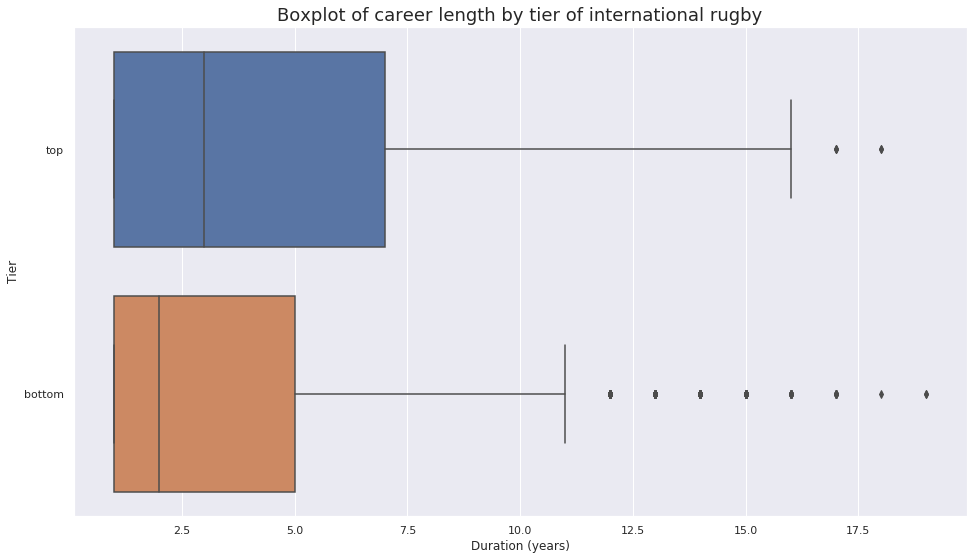

In [20]:
plot_boxplot(df_pro)

As we can see from the boxplot above, the median and IQR of career length is greater for the top tier teams however there appaears to be more players in the bottom tier who are outliers and these are likely the people who artifically extend their careers as mentioned above. Alongside this, there is greater turnover of players in the bottom tier teams for a multitude of financial, personal and political reasons so it is unsuprising the average career length is shorter

## Kaplan-Meier Estimator
In order to caluclate the survival estimates of career lengths, I will create a python class containing multiple functions to perform all the calulations. These will include:
* Calculate the conditional probability of surviving year by year - i.e. the probability of playing at time $t$ given a player made it to time $t-1$
* Caluclate the absolute probability fo a player still playing at time $t$
* Calculate the conditional median career length given a player makes it to time $t$
* Calculate the confidence intervals for the absolute survival scores using the formula given by [Kalbfleisch and Prentice (1980)](./Survival_analysis_confidence_intervals.pdf) where:  

\begin{align*}
Confidence\,Intervals\,&=\,exp(-exp(c_{+}(T)))\,\leq\,S(t)\,\leq\,exp(-exp(c_{-}(t))\\
c_{\pm}\,&=\,log(-log\hat{S}(t))\,\pm\,z_{\alpha/2}\sqrt{\hat{V}}\\
\hat{V}\,&=\,\frac{1}{\left(log\hat{S}(t)\right)^{2}}\displaystyle\sum_{t_{i}{\leq}{t}}\frac{d_{i}}{n_{i}(n_{i}-d_{i})}
\end{align*}

* Finally, plot the data

In [21]:
class KaplanMeier:
    """Class to calculate Kaplan-Meier Survival Rates"""
    
    def __init__(self):
        self.kmdict = {
            'removed':[],
            'observed':[],
            'censored':[],
            'entrance':[],
            'at_risk':[]
        }
        
    def fit_data(self, career_length, retired, return_df=False):
        """Calculate survival probabilities given duration of career and 
        whether event observed (i.e.retired)"""
        
        max_career = career_length.max()
        for i in range(max_career+1):
            total_players = career_length.shape[0]
            removed = (career_length == i).sum()
            censored = ((career_length == i) & (retired == 0)).sum()
            observed = removed - censored
            entrance = total_players if i == 0 else 0
            at_risk = total_players if i == 0 else (self.kmdict['at_risk'][i-1] - self.kmdict['removed'][i-1])
            self.kmdict['removed'].append(removed)
            self.kmdict['observed'].append(observed)
            self.kmdict['censored'].append(censored)
            self.kmdict['entrance'].append(entrance)
            self.kmdict['at_risk'].append(at_risk)
            self.km_df = pd.DataFrame(self.kmdict)
        
        if return_df: 
            return self.km_df
    
    def calc_survival(self, return_df=False):
        """Calculate the Kaplan-Meier estimator S(t) of the surivial function
        S(t) = Pr(T > t)) and calculate conditional probabilty given reaching t
        along with conditional median to retirement"""
        self.km_df['cond_survival'] = (self.km_df['at_risk'] - self.km_df['observed'])/self.km_df['at_risk']
        self.km_df['abs_survival'] = self.km_df['cond_survival'].cumprod()
        self.median_survival = np.argmax(self.km_df['abs_survival'] < 0.5)
        cond_median = {}
        for i in range(self.km_df.shape[0]):
            cond_median[i] = np.argmax(self.km_df['abs_survival'].iloc[i:] < self.km_df['abs_survival'].iloc[i]/2)
        self.km_df['conditional_median'] = cond_median.values()
            
        if return_df:
            return self.km_df[['cond_survival', 'abs_survival','conditional_median']]
    
    def confidence_intervals(self,return_df=False):
        self.km_df['d/(n(n-d))'] = self.km_df['observed']/(self.km_df['at_risk']*(self.km_df['at_risk']-self.km_df['observed']))
        self.km_df['sigma'] = self.km_df['d/(n(n-d))'].cumsum()
        self.km_df['V'] = (1/np.log(self.km_df['abs_survival'])**2)*self.km_df['sigma']
        self.km_df['c+'] = np.log(-np.log(self.km_df['abs_survival']))+(1.96*np.sqrt(self.km_df['V']))
        self.km_df['c-'] = np.log(-np.log(self.km_df['abs_survival']))-(1.96*np.sqrt(self.km_df['V']))
        self.km_df['ci_low'] = np.exp(-np.exp(self.km_df['c+']))
        self.km_df['ci_high'] = np.exp(-np.exp(self.km_df['c-']))
        
        if return_df:
            return self.km_df[['ci_low', 'ci_high']]
        
    
    def survival_plot(self):
        sns.set()
        plt.figure(figsize=(10,8))
        plt.step(self.km_df.index, self.km_df['abs_survival'], where='post')
        plt.title('Survival Plot')
        plt.xlabel('No of Years')
        plt.ylabel('Probablity')
        if 'ci_low' in self.km_df.columns:
            plt.fill_between(self.km_df.index, self.km_df['ci_low'], self.km_df['ci_high'], color='red', alpha=0.7, step='post')
    
    def conditional_plot(self):
        plt.figure(figsize=(10,8))
        plt.plot(self.km_df['conditional_median'])
        plt.xlabel('No of years played')
        plt.ylabel('Conditional median years to play')
        plt.title('Median number of years to play from reaching time t')
    
        
        

In [22]:
# Instantiate an instance of the class
km = KaplanMeier()

In [23]:
# Fit the class to the data
data = km.fit_data(df_pro['duration'], df_pro['retired'])

In [24]:
# Calculate the probability of survival
km.calc_survival(True)

,cond_survival,abs_survival,conditional_median
0,1.000000,1.000000,3
1,0.665798,0.665798,4
2,0.822577,0.547670,5
3,0.850930,0.466029,4
4,0.851597,0.396869,4
5,0.837283,0.332292,4
6,0.834817,0.277403,4
7,0.826141,0.229174,4
8,0.822096,0.188403,3
9,0.797428,0.150238,3


/home/grant/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


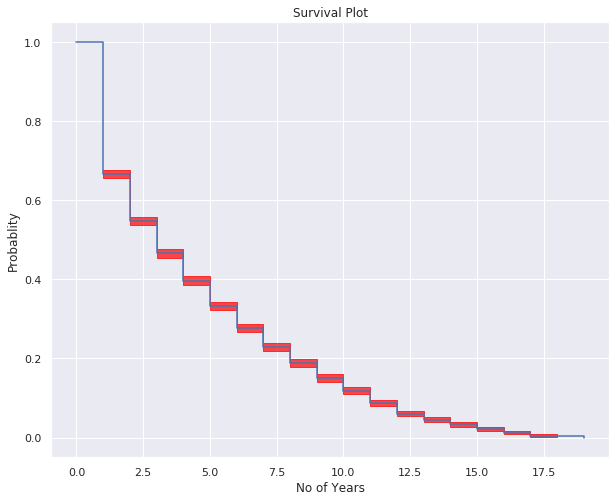

In [25]:
# Calculate the confidence intervals and plot the data
km.confidence_intervals()
km.survival_plot()

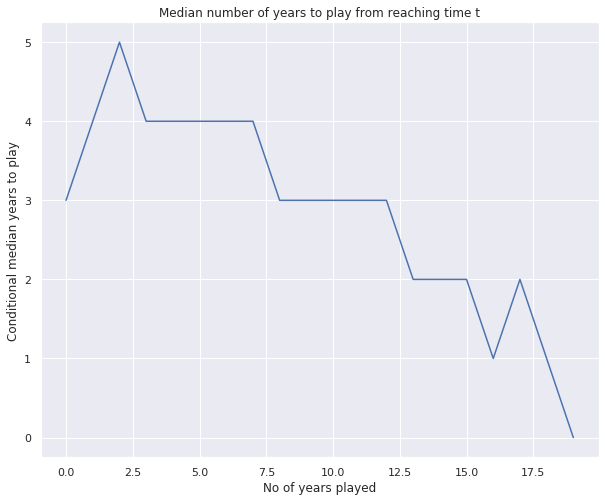

In [26]:
# Plot the conditional median number of years still to play given reaching year t
km.conditional_plot()

## Assessing survival plots acorss tier 1 countries
The previous analysis looked at all the tier 1 countries however we may be missing some difference *between* the countries. I will plot the data for each of these countries individually and analyze the results

/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/grant/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/grant/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/grant/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/grant/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: Runtime

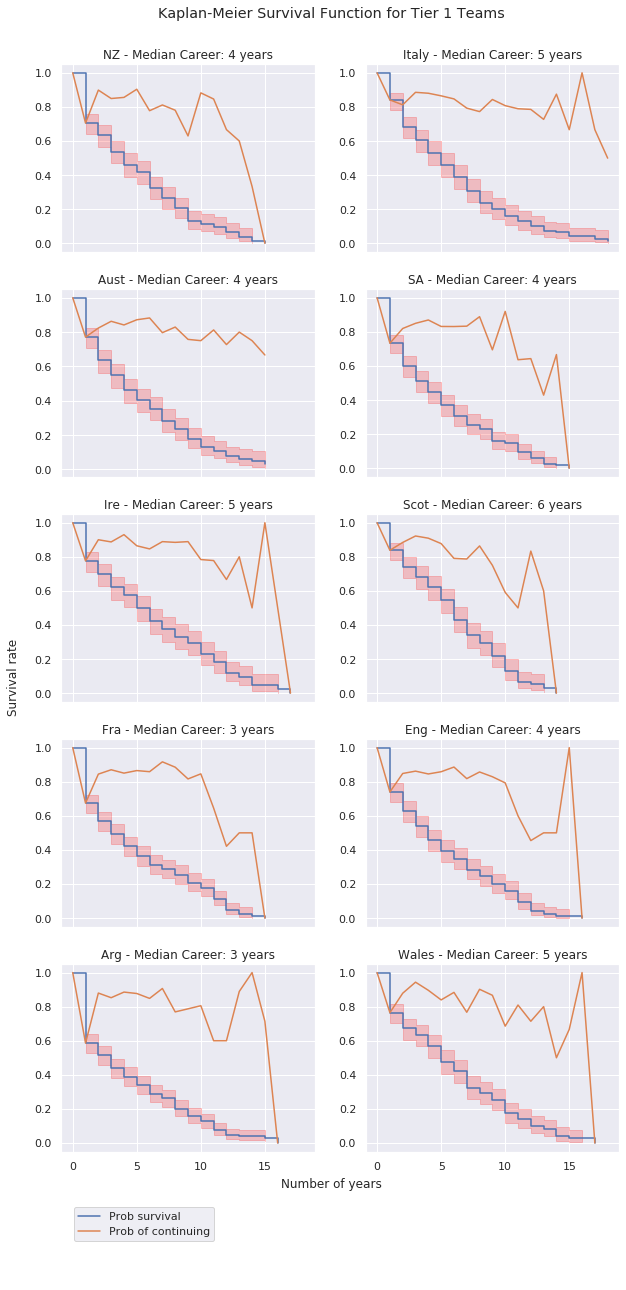

In [27]:
# Merge the data from any lions players into their respective country
lions_dict = {'Eng/Lions':'Eng',
             'Ire/Lions':'Ire',
             'Lions/Wales':'Wales',
             'Lions/Scot':'Scot'}

df_pro['country'] = df_pro['country'].replace(lions_dict)

countries = ['NZ','Italy','Aust','SA','Ire',
             'Scot','Fra','Eng','Arg','Wales']

fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(10,20),sharex=True, squeeze=False)
fig.suptitle('Kaplan-Meier Survival Function for Tier 1 Teams', y=0.92)
fig.text(0.43,0.1,'Number of years')
fig.text(0.05,0.43,'Survival rate',rotation=90)

for country, ax in zip(countries, axes.flatten()):
    temp_df = df_pro[df_pro['country'] == country]
    km_ = KaplanMeier()
    km_.fit_data(temp_df['duration'], temp_df['retired'])
    km_.calc_survival()
    km_.confidence_intervals()
    ax.set_title(f'{country} - Median Career: {km_.median_survival} years')
    ax.step(km_.km_df.index, km_.km_df['abs_survival'],where='post',label='Prob survival')
    ax.fill_between(km_.km_df.index, km_.km_df['ci_low'], km_.km_df['ci_high'], color='red', alpha=0.2, step='post')
    ax.plot(km_.km_df['cond_survival'], label='Prob of continuing')
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.2,0.03),loc='lower center')

From the graphs above, it would appear that most countries follow a similar trend over the first 10 years with roughly an 80% chance of playing the following year given reaching a given year. Australia and Italy seem to be the two countries where this trend stays similar up towards 15 years suggesting longer careers in these countries. In Italy's case it could be that given they have a smaller talent pool to select from, the better players have less competition and play on for longer.  
Argentina have the largest drop off after year 1 suggesting they have a lot of players who play only a few times for the country. Argentina would be a country without the depth of players to select from compared to some other countries so it may be the case they often have to select people who won't have sutained international careers due to during injuries etc. It may also be that they select more players in order to give them a chance to prove themselves and are happy to not select them again if they aren't good enough.  
Several coutries seem to have a spike at 14-15 years in conditional survival which I would suggest is down to one of two players who happen to make it to a 14th season and subsequently a 15th making the conditional probabilty of surviving to a 15th season having reached the 14th is exactly 1.

## Further Analysis and Limitations
This analysis has looked at the length of international rugby careers and the probablity of playing from one year to the next. Furthermore, I have examined the differences between tier 1 and tier 2 countries and then between teams in tier 1.  
Further analysis would look at the differences in survival between positions as there would likely be certain age profiles for different playing positions. One weakness of the data is that it does not take into account any gaps in a players career but merely the years between their first and last international match so some players may have played one year, not played for several years before being selected again.

### References
See hyperlinks within Markdown blocks